<a href="https://colab.research.google.com/github/AOdrio/Datathon/blob/main/bolaso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [201]:
import pandas as pd
import numpy as np

import xgboost as xgb
from matplotlib import pyplot as plt
import seaborn as sns 

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression as LR
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.preprocessing import QuantileTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')

SEED = 42

In [2]:
url='https://drive.google.com/file/d/1KH1fB83JDAWcMRCHKFf9SmcGH7MQkupE/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df_original = pd.read_csv(url)

In [ ]:
df_original.describe()

In [ ]:
ax = df_original.hist(bins=20, figsize=(15, 10))

se remplazan los null por la media de la columna

In [131]:
edad_media = df_original['edad'].mean()
edad_media

45.02159532392986

In [237]:
def transfromar_DataFrame (df):
  df = df.copy()
  df = df.drop(df.columns[0],axis=1)
  #Remplazar nulls de la edad con la media de la columna
  df['edad'] = df['edad'].fillna(edad_media, inplace=False)

  #Transformar categóricas en numéricas
  df['peorcalificacionBCU'] = (df['peorcalificacionBCU'].
                              str.replace('5','6').
                              str.replace('4','5').
                              str.replace('3','4').
                              str.replace('2B','3').
                              str.replace('2A','2').
                              str.replace('1C','1').
                              str.replace('1A','0'))
  df['peorcalificacionBCU'] = pd.to_numeric(df['peorcalificacionBCU'], downcast='integer')
  return df

In [238]:
df = transfromar_DataFrame(df_original)


In [ ]:
df.head()

In [239]:
y = df.pop("ingreso")
X = df.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)


In [108]:
# La linea base es el mediana de los ingresos
baseline_preds = pd.DataFrame(y_train.copy())
mediana = y_train.median()
baseline_preds['mediana'] = mediana
# Baseline errors, and display average baseline error
baseline_MAPE = MAPE(y_train,baseline_preds['mediana'])
print('MAPE linea base: ', round(baseline_MAPE *100, 2))
print('Mediana de ingreso: ', round(mediana))

MAPE linea base:  42.18
Mediana de ingreso:  53665


In [70]:
rf = RandomForestRegressor(n_estimators = 500, random_state = SEED)

In [113]:
rf = RandomForestRegressor(n_estimators = 500, random_state = SEED)
rf.fit(X_train,y_train)
preds_rf = rf.predict(X_test)
MAPE_rf = MAPE(y_test, preds_rf)
print('MAPE_rf:', round(100*MAPE_rf, 2))

MAPE_rf: 12.93


In [71]:
pipe_rf = Pipeline([('scaler',StandardScaler()),('model',rf)])
pipe_rf.fit(X_train,y_train)
preds_rf = pipe_rf.predict(X_test)
MAPE_rf = MAPE(y_test, preds_rf)
print('MAPE_rf:', round(100*MAPE_rf, 2))

MAPE_rf: 12.94


In [72]:
pipe_rf = Pipeline([('t',QuantileTransformer(n_quantiles=100, output_distribution='normal')),('model',rf)])
pipe_rf.fit(X_train,y_train)
preds_rf = pipe_rf.predict(X_test)
MAPE_rf = MAPE(y_test, preds_rf)
print('MAPE_rf:', round(100*MAPE_rf, 2))

MAPE_rf: 12.94


In [73]:
pipe_rf = Pipeline([('t',QuantileTransformer(n_quantiles=100, output_distribution='uniform')),('model',rf)])
pipe_rf.fit(X_train,y_train)
preds_rf = pipe_rf.predict(X_test)
MAPE_rf = MAPE(y_test, preds_rf)
print('MAPE_rf:', round(100*MAPE_rf, 2))

MAPE_rf: 12.95


In [ ]:
# Use the forest's predict method on the test data
preds_rf = rf.predict(X_test)
# Calculate the absolute percentage errors
MAPE_rf = MAPE(y_test, preds_rf)
# Print out the mean absolute percentageerror (mape)
print('MAPE_rf:', round(100*MAPE_rf, 2))

In [240]:
model_xgb = xgb.XGBRegressor(
            objective = "reg:squarederror",
            eval_metric = "mae",
            tree_method = "gpu_hist",
            booster = "gbtree",
            random_state = SEED,
            n_estimators = 500,
            learning_rate = 0.01,
            max_depth = 11,
            min_child_weight = 7,
            subsample = 0.9,
            colsample_bytree = 1,
            colsample_bynode = 0.7,
            colsample_bylevel = 0.8,
            verbosity = 0,
            n_jobs = -1,
            )

In [241]:
model_xgb.fit(X_train,y_train)
preds_xgb = model_xgb.predict(X_test)
MAPE_xgb = MAPE(y_test, preds_xgb)
print('MAPE_xgb:', round(100*MAPE_xgb, 2))

MAPE_xgb: 12.49


In [189]:
pipe_xgb = Pipeline([('scaler',StandardScaler()),('model',model_xgb)])
pipe_xgb.fit(X_train,y_train)
preds_xgb = pipe_xgb.predict(X_test)
MAPE_xgb = MAPE(y_test, preds_xgb)
print('MAPE_xgb:', round(100*MAPE_xgb, 2))

MAPE_xgb: 12.49


In [228]:
df1 = df_original.drop(df_original.columns[0],axis=1)

In [229]:
y = df1.pop("ingreso")
X = df1.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [235]:
numeric_features = list(df1.columns[df1.columns!= 'peorcalificacionBCU'])
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))])

categorical_features = ['peorcalificacionBCU']
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
pipe_xgb2 = Pipeline( steps=[("preprocessor", preprocessor), ("modelo", model_xgb)])

pipe_xgb2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['vigente', 'vigenteAvg3M',
                                                   'vencido', 'vencidoAvg3M',
                                                   'avgcontingenciaU1M',
                                                   'avgcontingenciaU3M',
                                                   'sumcontingenciaU1M',
                                                   'sumcontingenciaU3M',
                                                   'maxcontingenciaU1M',
                                                   'maxcontingenciaU3M',
                                                   'numcontingenciaU1M',
                                                   'garantiac

In [236]:
preds_xgb2 = pipe_xgb2.predict(X_test)
MAPE_xgb2 = MAPE(y_test, preds_xgb2)
print('MAPE_xgb:', round(100*MAPE_xgb2, 2))

MAPE_xgb: 12.5


Text(0.5, 0, 'Xgboost Feature Importance')

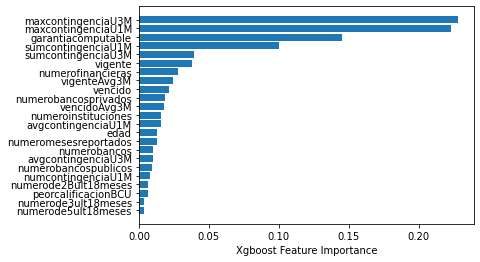

In [242]:
sorted_idx = model_xgb.feature_importances_.argsort()
plt.barh(list(X_train.columns[sorted_idx]), model_xgb.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

Se hace la prueba de una regresión lineal con las columnas más influyentes

In [135]:
X_train_LR = X_train[['maxcontingenciaU3M','garantiacomputable','numerofinancieras','edad','vencido','vigente']]
X_test_LR = X_test[['maxcontingenciaU3M','garantiacomputable','numerofinancieras','edad','vencido','vigente']]

In [136]:
pipe_LR = Pipeline([('scaler',StandardScaler()),('model',LR())])
pipe_LR.fit(X_train_LR,y_train)
preds_LR = pipe_LR.predict(X_test_LR)
MAPE_LR = MAPE(y_test, preds_LR)
print('MAPE_LR:', round(100*MAPE_LR, 2))

MAPE_LR: 19.54


lo mismo con knn

In [137]:
pipe_KNN = Pipeline([('scaler',StandardScaler()),('model',KNN(n_neighbors=50))])
pipe_KNN.fit(X_train_LR,y_train)
preds_KNN = pipe_KNN.predict(X_test_LR)
MAPE_KNN = MAPE(y_test, preds_KNN)
print('MAPE_KNN:', round(100*MAPE_KNN, 2))

MAPE_KNN: 15.58


In [176]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:linear',
    'eval_metric':'mae',
    'tree_method' : 'gpu_hist',
}

In [163]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=999,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[01:58:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-mae:47179.6
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:33009.5
[2]	Test-mae:23499.8
[3]	Test-mae:17619.1
[4]	Test-mae:14238.5
[5]	Test-mae:12490.9
[6]	Test-mae:11602
[7]	Test-mae:11150.9
[8]	Test-mae:10971.3
[9]	Test-mae:10836.4
[10]	Test-mae:10703.3
[11]	Test-mae:10600.3
[12]	Test-mae:10571.4
[13]	Test-mae:10530.6
[14]	Test-mae:10490.4
[15]	Test-mae:10409.7
[16]	Test-mae:10361.5
[17]	Test-mae:10350
[18]	Test-mae:10303.9
[19]	Test-mae:10264.7
[20]	Test-mae:10233.4
[21]	Test-mae:10225.6
[22]	Test-mae:10208.1
[23]	Test-mae:10198.7
[24]	Test-mae:10166.4
[25]	Test-mae:10152.1
[26]	Test-mae:10145.2
[27]	Test-mae:10130.8
[28]	Test-mae:10140
[29]	Test-mae:10131.7
[30]	Test-mae:10143.2
[31]	Test-mae:10139.5
[32]	Test-mae:10150.5
[33]	Test-mae:10156.3
[34]	Test-mae:10110.3
[35]	Test-mae:10113.7
[36]	Test-mae:10109.5
[37]	Test-mae:10077

In [ ]:
print("Best MAE: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

Best MAE: 10029.66 with 49 rounds


In [ ]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]

In [ ]:
# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))    
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight    
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=999,
        seed=SEED,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )    
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
    
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

In [177]:
params['max_depth'] = 9
params['min_child_weight'] = 7

In [ ]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [ ]:
min_mae = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))    
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample    
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=999,
        seed=SEED,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )  
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

In [178]:
params['subsample'] = 0.9
params['colsample_bytree'] = 1

In [ ]:

# This can take some time…
min_mae = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))    
    # We update our parameters
    params['eta'] = eta    
    # Run and time CV
    cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=999,
            seed=SEED,
            nfold=5,
            metrics=['mae'],
            early_stopping_rounds=10
          )    
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta
print("Best params: {}, MAE: {}".format(best_params, min_mae))

In [179]:
params['eta'] = 0.01

In [ ]:
params

{'colsample_bytree': 0.7,
 'eta': 0.01,
 'eval_metric': 'mae',
 'max_depth': 9,
 'min_child_weight': 7,
 'objective': 'reg:linear',
 'subsample': 0.7,
 'tree_method': 'gpu_hist'}

In [180]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=999,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[02:12:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-mae:66824
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:66159.2
[2]	Test-mae:65502.5
[3]	Test-mae:64849.6
[4]	Test-mae:64205.4
[5]	Test-mae:63564.2
[6]	Test-mae:62931.6
[7]	Test-mae:62304.7
[8]	Test-mae:61684.8
[9]	Test-mae:61070.7
[10]	Test-mae:60463.6
[11]	Test-mae:59862.2
[12]	Test-mae:59263.6
[13]	Test-mae:58673.3
[14]	Test-mae:58089.2
[15]	Test-mae:57511.3
[16]	Test-mae:56939
[17]	Test-mae:56372.2
[18]	Test-mae:55810.1
[19]	Test-mae:55252.8
[20]	Test-mae:54702
[21]	Test-mae:54158.3
[22]	Test-mae:53619.9
[23]	Test-mae:53087.6
[24]	Test-mae:52559.2
[25]	Test-mae:52035.6
[26]	Test-mae:51517.3
[27]	Test-mae:51003.3
[28]	Test-mae:50495.9
[29]	Test-mae:49995
[30]	Test-mae:49497.6
[31]	Test-mae:49003.4
[32]	Test-mae:48517.4
[33]	Test-mae:48035
[34]	Test-mae:47558.6
[35]	Test-mae:47086.1
[36]	Test-mae:46615.9
[37]	Test-mae:46154.5
[

In [181]:
num_boost_round = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")]
)

[02:12:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-mae:66824
[1]	Test-mae:66159.2
[2]	Test-mae:65502.5
[3]	Test-mae:64849.6
[4]	Test-mae:64205.4
[5]	Test-mae:63564.2
[6]	Test-mae:62931.6
[7]	Test-mae:62304.7
[8]	Test-mae:61684.8
[9]	Test-mae:61070.7
[10]	Test-mae:60463.6
[11]	Test-mae:59862.2
[12]	Test-mae:59263.6
[13]	Test-mae:58673.3
[14]	Test-mae:58089.2
[15]	Test-mae:57511.3
[16]	Test-mae:56939
[17]	Test-mae:56372.2
[18]	Test-mae:55810.1
[19]	Test-mae:55252.8
[20]	Test-mae:54702
[21]	Test-mae:54158.3
[22]	Test-mae:53619.9
[23]	Test-mae:53087.6
[24]	Test-mae:52559.2
[25]	Test-mae:52035.6
[26]	Test-mae:51517.3
[27]	Test-mae:51003.3
[28]	Test-mae:50495.9
[29]	Test-mae:49995
[30]	Test-mae:49497.6
[31]	Test-mae:49003.4
[32]	Test-mae:48517.4
[33]	Test-mae:48035
[34]	Test-mae:47558.6
[35]	Test-mae:47086.1
[36]	Test-mae:46615.9
[37]	Test-mae:46154.5
[38]	Test-mae:45696.6
[39]	Test-mae:45241.3
[40]	Test-mae

In [182]:
preds_tuned = best_model.predict(dtest)
# Calculate the absolute percentage errors
MAPE_tuned = MAPE(y_test, preds_tuned)
print('MAPE_tuned:', round(100*MAPE_tuned, 2))

MAPE_tuned: 12.65


In [ ]:
#data de test
url='https://drive.google.com/file/d/1sMkorQLOmf2cNGRwXkQLKeciGSUpL_ez/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df_test_original = pd.read_csv(url)

df_test_original.head()

,Unnamed: 0,vigente,vigenteAvg3M,vencido,vencidoAvg3M,avgcontingenciaU1M,avgcontingenciaU3M,sumcontingenciaU1M,sumcontingenciaU3M,maxcontingenciaU1M,...,numeroinstituciones,numerobancosprivados,numerobancospublicos,numerofinancieras,numerobancos,numerode5ult18meses,numerode2Bult18meses,numerode3ult18meses,edad,numeromesesreportados
0,40001,10725.957382,11480.961340,0.0,0.0,19510.697566,23402.938295,19510.697566,20719.358643,19510.697566,...,2,0,0,2,0,0,3,0,29.0,24
1,40002,82242.277287,77710.508800,0.0,0.0,13968.618508,14816.095112,27937.237016,23324.599806,17527.530907,...,5,0,1,4,1,0,1,0,66.0,24
2,40003,1646.607555,1836.928522,0.0,0.0,71846.928147,68585.407866,71846.928147,83632.771011,71846.928147,...,2,2,0,0,2,0,4,0,35.0,24
3,40004,8740.977410,8640.764002,0.0,0.0,24560.879097,26136.018124,49121.758195,48865.156174,42492.834450,...,2,1,1,0,2,0,0,0,54.0,24
4,40005,365107.557629,366550.793336,0.0,0.0,13879.429839,11677.655495,27758.859677,28020.443219,23587.864067,...,2,1,1,0,2,0,1,0,NaN,19


In [ ]:
df_test = transfromar_DataFrame(df_test_original)


In [ ]:
d_test = xgb.DMatrix(df_test)

In [ ]:
preds_datathon = best_model.predict(d_test)

In [ ]:
pd.DataFrame(preds_datathon).to_csv('predicciones.csv') 